training SNN

In [12]:
import torch
from spikingjelly.activation_based import neuron
import torch.nn as nn
import spikingjelly.activation_based.surrogate as surrogate
import spikingjelly.activation_based.layer as layer

In [13]:
# ANN
nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 10, bias=False),
    nn.Softmax(),
)

# SNN
tau = 2.0
nn.Sequential(
    layer.Flatten(),
    layer.Linear(28*28, 10, bias=False),
    neuron.LIFNode(tau=tau, surrogate_function=surrogate.ATan()),
)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1, step_mode=s)
  (1): Linear(in_features=784, out_features=10, bias=False)
  (2): LIFNode(
    v_threshold=1.0, v_reset=0.0, detach_reset=False, step_mode=s, backend=torch, tau=2.0
    (surrogate_function): ATan(alpha=2.0, spiking=True)
  )
)

Namespace(T=1, device='cuda:0', b=64, epochs=3, j=4, data_dir='./data', out_dir='./logs', resume=None, amp=False, opt='adam', momentum=0.9, lr=0.001, tau=2.0)
SNN(
  (layer): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1, step_mode=s)
    (1): Linear(in_features=784, out_features=10, bias=False)
    (2): LIFNode(
      v_threshold=1.0, v_reset=0.0, detach_reset=False, step_mode=s, backend=torch, tau=2.0
      (surrogate_function): ATan(alpha=2.0, spiking=True)
    )
  )
)
Namespace(T=1, device='cuda:0', b=64, epochs=3, j=4, data_dir='./data', out_dir='./logs', resume=None, amp=False, opt='adam', momentum=0.9, lr=0.001, tau=2.0)
./logs/T1_b64_adam_lr0.001
epoch =0, train_loss = 0.0444, train_acc = 0.6741, test_loss = 0.0315, test_acc = 0.7749, max_test_acc = 0.7749
train speed = 11620.9938 images/s, test speed = 10674.1779 images/s
escape time = 2026-02-05 07:57:20

Namespace(T=1, device='cuda:0', b=64, epochs=3, j=4, data_dir='./data', out_dir='./logs', resume=None, amp=False, o

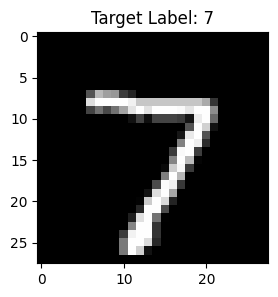

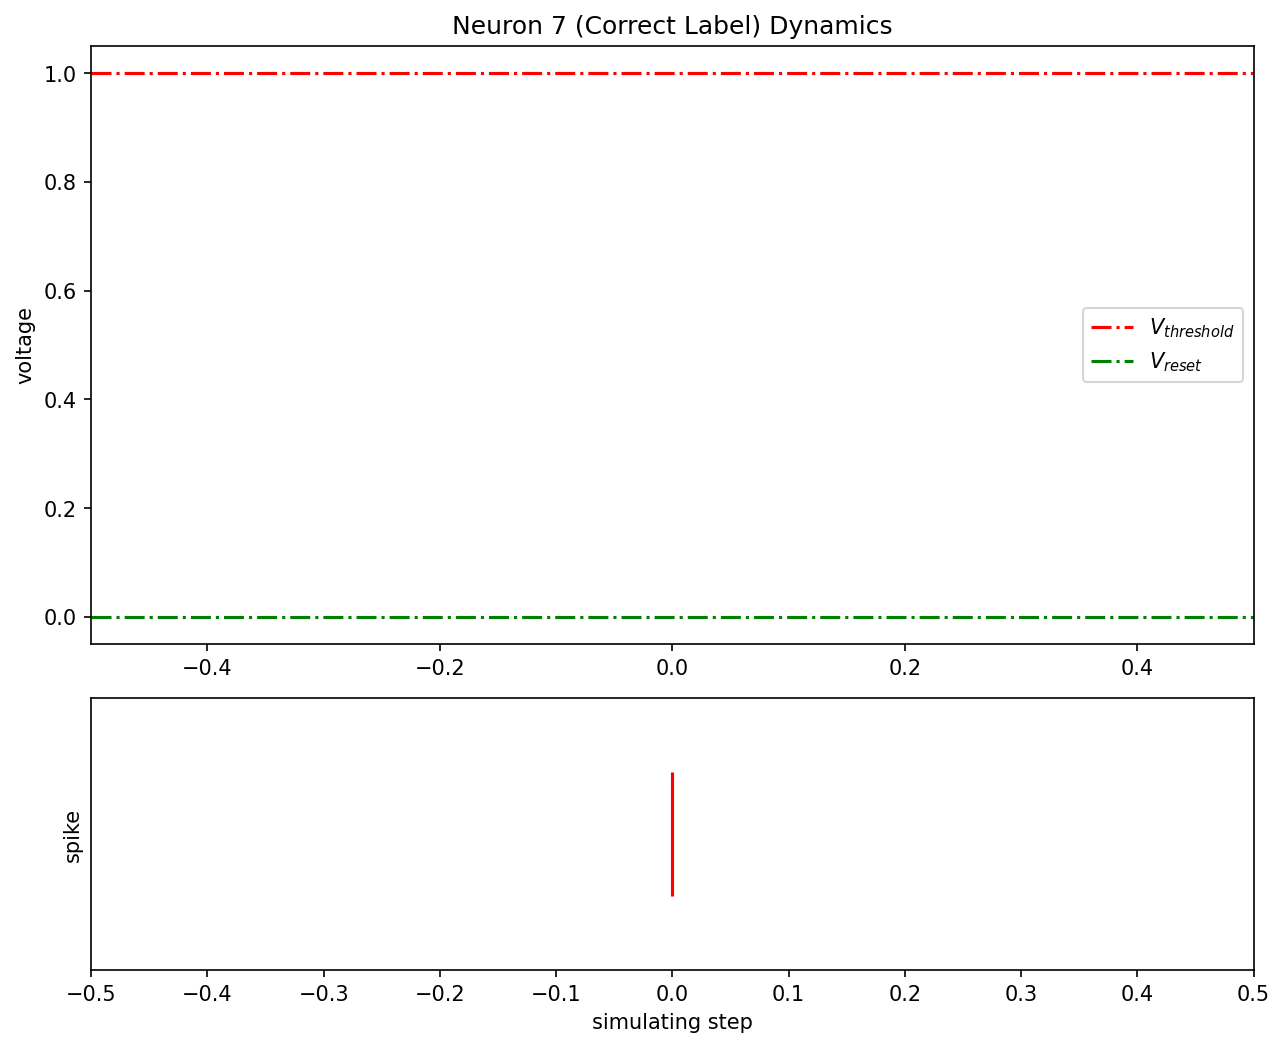

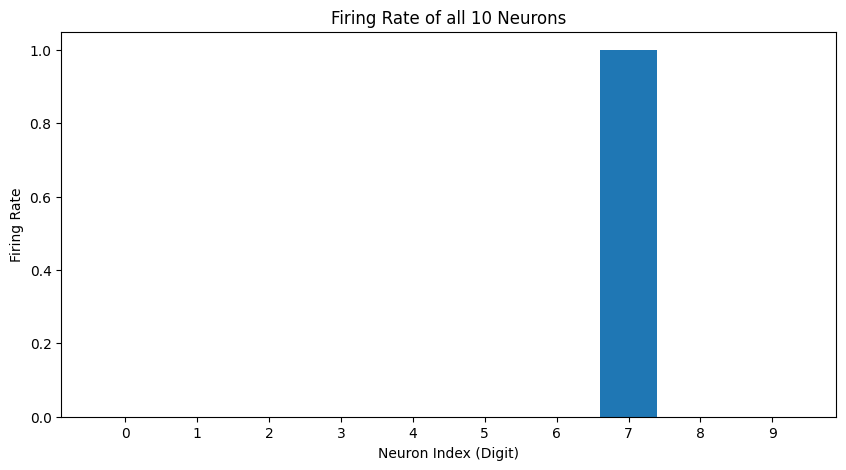

In [14]:
import os
import time
import argparse
import sys
import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from torch.cuda import amp
from torch.utils.tensorboard import SummaryWriter
import torchvision
import numpy as np
import matplotlib.pyplot as plt

from spikingjelly.activation_based import neuron, encoding, functional, surrogate, layer
from spikingjelly import visualizing


class SNN(nn.Module):
    def __init__(self, tau):
        super().__init__()

        self.layer = nn.Sequential(
            layer.Flatten(),
            layer.Linear(28 * 28, 10, bias=False),
            neuron.LIFNode(tau=tau, surrogate_function=surrogate.ATan()),
        )

    def forward(self, x: torch.Tensor):
        return self.layer(x)


def main():
    parser = argparse.ArgumentParser(description="LIF MNIST Training")
    parser.add_argument("-T", default=1, type=int, help="simulating time-steps")
    parser.add_argument("-device", default="cuda:0", help="device")
    parser.add_argument("-b", default=64, type=int, help="batch size")
    parser.add_argument(
        "-epochs",
        default=3,
        type=int,
        metavar="N",
        help="number of total epochs to run",
    )
    parser.add_argument(
        "-j",
        default=4,
        type=int,
        metavar="N",
        help="number of data loading workers (default: 4)",
    )
    parser.add_argument(
        "-data-dir", type=str, default="./data", help="root dir of MNIST dataset") # Added default value
    parser.add_argument(
        "-out-dir",
        type=str,
        default="./logs",
        help="root dir for saving logs and checkpoint",
    )
    parser.add_argument("-resume", type=str, help="resume from the checkpoint path")
    parser.add_argument(
        "-amp", action="store_true", help="automatic mixed precision training"
    )
    parser.add_argument(
        "-opt",
        type=str,
        choices=["sgd", "adam"],
        default="adam",
        help="use which optimizer. SGD or Adam",
    )
    parser.add_argument("-momentum", default=0.9, type=float, help="momentum for SGD")
    parser.add_argument("-lr", default=1e-3, type=float, help="learning rate")
    parser.add_argument(
        "-tau", default=2.0, type=float, help="parameter tau of LIF neuron"
    )

    args = parser.parse_args([]) # 로컬에서는 args = parser.parse_args()
    print(args)

    net = SNN(tau=args.tau)

    print(net)

    net.to(args.device) # 모델을 gpu(계산장치)로 보냄

    train_dataset = torchvision.datasets.MNIST(
        root=args.data_dir,
        train=True,
        transform=torchvision.transforms.ToTensor(),
        download=True,
    )
    test_dataset = torchvision.datasets.MNIST(
        root=args.data_dir,
        train=False,
        transform=torchvision.transforms.ToTensor(),
        download=True,
    )

    train_data_loader = data.DataLoader(
        dataset=train_dataset,
        batch_size=args.b,
        shuffle=True, # 매 epoch 시작마다 데이터 섞기
        drop_last=True, # 남는 자투리 데이터 버린다
        num_workers=args.j,
        pin_memory=True, # 메모리 고정
    )
    test_data_loader = data.DataLoader(
        dataset=test_dataset,
        batch_size=args.b,
        shuffle=False,
        drop_last=False,
        num_workers=args.j,
        pin_memory=True,
    )

    scaler = None
    if args.amp:
        scaler = amp.GradScaler() # 연산 정밀도 자동 조절

    start_epoch = 0
    max_test_acc = -1

    # optimizer 선택
    optimizer = None
    if args.opt == "sgd":
        optimizer = torch.optim.SGD(
            net.parameters(), lr=args.lr, momentum=args.momentum
        )
    elif args.opt == "adam": # 보통 이걸 많이 쓴다
        optimizer = torch.optim.Adam(net.parameters(), lr=args.lr)
    else:
        raise NotImplementedError(args.opt)

    if args.resume: # 학습할때 저장 포인트에서 학습 재개
        checkpoint = torch.load(args.resume, map_location="cpu")
        net.load_state_dict(checkpoint["net"])
        optimizer.load_state_dict(checkpoint["optimizer"])
        start_epoch = checkpoint["epoch"] + 1
        max_test_acc = checkpoint["max_test_acc"]

    out_dir = os.path.join(args.out_dir, f"T{args.T}_b{args.b}_{args.opt}_lr{args.lr}") # 결과물 저장

    # 폴더 생성
    if args.amp:
        out_dir += "_amp" # 이름에 _amp 붙이기

    if not os.path.exists(out_dir):
        os.makedirs(out_dir)
        print(f"Mkdir {out_dir}.")

    # 사용한 하이퍼파라미터, 명령어 텍스트 파일로 저장
    writer = SummaryWriter(out_dir, purge_step=start_epoch) # tensorboard 시각화 도구 사용 준비
    with open(os.path.join(out_dir, "args.txt"), "w", encoding="utf-8") as args_txt:
        args_txt.write(str(args))
        args_txt.write("\n")
        args_txt.write(" ".join(sys.argv))

    encoder = encoding.PoissonEncoder()

    for epoch in range(start_epoch, args.epochs): # 전체 사진(60000장)을 몇번 반복할건가
        start_time = time.time()
        net.train() # 학습모드로 만들기
        # epoch마다 변수들 초기화
        train_loss = 0
        train_acc = 0
        train_samples = 0
        for img, label in train_data_loader: # batch_size(64장)씩 묶어서 몇번 가져올건가
            optimizer.zero_grad() # 기울기 초기화
            img = img.to(args.device)
            label = label.to(args.device)
            label_onehot = F.one_hot(label, 10).float() # 정답 원핫 인코딩으로

            if scaler is not None:
                with amp.autocast():
                    out_fr = 0.0
                    for t in range(args.T): # T만큼 반복
                        encoded_img = encoder(img) # 스파이크 생성
                        out_fr += net(encoded_img) # firing rate 누적
                    out_fr = out_fr / args.T # firing rate 평균
                    loss = F.mse_loss(out_fr, label_onehot) # 정답과 비교 => 오차가 크면 가중치 수정해서 다른 숫자의 뉴런이 더 반응하게 만들어
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                out_fr = 0.0
                for t in range(args.T): # 가져온 64장 사진을 뉴런에게 몇초(T)동안 보여줄건가
                    encoded_img = encoder(img)
                    out_fr += net(encoded_img)
                out_fr = out_fr / args.T
                loss = F.mse_loss(out_fr, label_onehot) # F.mse_loss : 정답뉴런은 1.0으로 나머지는 0.0으로 만들어 훈련
                loss.backward() # 역전파 기울기 계산
                optimizer.step() # 가중치 업데이트

            train_samples += label.numel() # 학습한 배치 수 더하기
            train_loss += loss.item() * label.numel() # 오차 누적
            train_acc += (out_fr.argmax(1) == label).float().sum().item() # 맞힌 개수 누적. 정답과 같으면 True(1), 다르면 False(0)

            functional.reset_net(net) # 뉴런 초기화

        train_time = time.time()
        train_speed = train_samples / (train_time - start_time) # 학습 속도 계산
        train_loss /= train_samples # 최종 평균 오차
        train_acc /= train_samples # 최종 평균 정확도

        writer.add_scalar("train_loss", train_loss, epoch)
        writer.add_scalar("train_acc", train_acc, epoch)

        net.eval() # 검증 단계
        test_loss = 0
        test_acc = 0
        test_samples = 0
        with torch.no_grad(): # 기울기 계산 멈춤(backpropogation 안함)
            for img, label in test_data_loader:
                img = img.to(args.device)
                label = label.to(args.device)
                label_onehot = F.one_hot(label, 10).float()
                out_fr = 0.0
                for t in range(args.T):
                    encoded_img = encoder(img)
                    out_fr += net(encoded_img)
                out_fr = out_fr / args.T
                loss = F.mse_loss(out_fr, label_onehot)

                test_samples += label.numel()
                test_loss += loss.item() * label.numel()
                test_acc += (out_fr.argmax(1) == label).float().sum().item()
                functional.reset_net(net)
        test_time = time.time()
        test_speed = test_samples / (test_time - train_time)
        test_loss /= test_samples
        test_acc /= test_samples
        writer.add_scalar("test_loss", test_loss, epoch)
        writer.add_scalar("test_acc", test_acc, epoch)

        save_max = False
        # 정확도가 가장 높다면 그 모델은 따로 저장한다
        if test_acc > max_test_acc:
            max_test_acc = test_acc
            save_max = True

        checkpoint = {
            "net": net.state_dict(),
            "optimizer": optimizer.state_dict(),
            "epoch": epoch,
            "max_test_acc": max_test_acc,
        }

        if save_max:
            torch.save(checkpoint, os.path.join(out_dir, "checkpoint_max.pth"))

        torch.save(checkpoint, os.path.join(out_dir, "checkpoint_latest.pth"))

        print(args)
        print(out_dir)
        print(
            f"epoch ={epoch}, train_loss ={train_loss: .4f}, train_acc ={train_acc: .4f}, test_loss ={test_loss: .4f}, test_acc ={test_acc: .4f}, max_test_acc ={max_test_acc: .4f}"
        )
        print(
            f"train speed ={train_speed: .4f} images/s, test speed ={test_speed: .4f} images/s"
        )
        print(
            f"escape time = {(datetime.datetime.now() + datetime.timedelta(seconds=(time.time() - start_time) * (args.epochs - epoch))).strftime('%Y-%m-%d %H:%M:%S')}\n"
        )

    net.eval()
    # 등록 후킹
    output_layer = net.layer[-1]  # 출력층
    output_layer.v_seq = []
    output_layer.s_seq = []

    def save_hook(m, x, y):
        m.v_seq.append(m.v.unsqueeze(0))
        m.s_seq.append(y.unsqueeze(0))

    output_layer.register_forward_hook(save_hook)

    with torch.no_grad():
        img, label = test_dataset[0]
        img = img.to(args.device)
        out_fr = 0.0
        for t in range(args.T):
            encoded_img = encoder(img)
            out_fr += net(encoded_img)
        out_spikes_counter_frequency = (out_fr / args.T).cpu().numpy()
        print(f"Firing rate: {out_spikes_counter_frequency}")

        output_layer.v_seq = torch.cat(output_layer.v_seq)
        output_layer.s_seq = torch.cat(output_layer.s_seq)
        v_t_array = (
            output_layer.v_seq.cpu().numpy().reshape(args.T, -1)
        )  # v_t_array[i][j]는 뉴런 i의 j 시점 전압값
        np.save("v_t_array.npy", v_t_array)
        s_t_array = (
            output_layer.s_seq.cpu().numpy().reshape(args.T, -1)
        )  # s_t_array[i][j]는 뉴런 i의 j 시점 스파이크 발생 여부(0 또는 1)
        np.save("s_t_array.npy", s_t_array)

        print("시각화를 시작합니다...")

    # 1. Accuracy 변화율 그래프 (TensorBoard 대신 matplotlib으로 간단히 확인)
    # 실제 프로젝트에서는 기록된 로그를 읽어와야 하지만, 여기서는 튜토리얼용으로 흐름만 잡습니다.

    # 2. 첫 번째 테스트 이미지 보여주기
        img_first, label_first = test_dataset[0]
        plt.figure(figsize=(3, 3))
        plt.imshow(img_first.squeeze(), cmap='gray')
        plt.title(f"Target Label: {label_first}")
        plt.show()

    # 3. Firing Rate, Voltage, Spike 시각화
    # 아까 저장한 v_t_array와 s_t_array를 활용합니다.
    # v_t_array shape: [T, 10], s_t_array shape: [T, 10]

    #
    # SpikingJelly의 내부 시각화 도구 사용
        visualizing.plot_one_neuron_v_s(
            v_t_array[:, label_first], # 정답 레이블 뉴런의 전압
            s_t_array[:, label_first], # 정답 레이블 뉴런의 스파이크
            v_threshold=net.layer[-1].v_threshold,
            v_reset=net.layer[-1].v_reset,
            title=f"Neuron {label_first} (Correct Label) Dynamics",
            figsize=(10, 8),
            dpi=150
        )
        plt.show()

    # 10개 뉴런 전체의 Firing Rate를 막대그래프로 시각화
        plt.figure(figsize=(10, 5))
        plt.bar(range(10), out_spikes_counter_frequency.flatten())
        plt.title("Firing Rate of all 10 Neurons")
        plt.xlabel("Neuron Index (Digit)")
        plt.ylabel("Firing Rate")
        plt.xticks(range(10))
        plt.show()


if __name__ == "__main__":
    main()

In [15]:
import numpy as np
import matplotlib.pyplot as plt

In [29]:
test_dataset = torchvision.datasets.MNIST(
    root="./data",        # main 함수의 args.data_dir와 동일한 경로
    train=False,          # 테스트용 데이터
    transform=torchvision.transforms.ToTensor(),
    download=True
)
# --- 1. 설정 및 모델 불러오기 ---
test_idx = 1  # 여기서 인덱스 수정
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 저장된 모델 불러오기 (args.tau가 2.0이었다고 가정)
model = SNN(tau=2.0)
# 실제 경로에 맞춰 수정하세요 (예: logs/T1_.../checkpoint_max.pth)
checkpoint_path = "logs/T1_b64_adam_lr0.001/checkpoint_max.pth"
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint["net"])
model.to(device)
model.eval()

# --- 2. 특정 데이터 준비 ---
# test_dataset이 이미 메모리에 있다면 그대로 쓰고, 없다면 아래 주석 해제
# test_dataset = torchvision.datasets.MNIST(root="./data", train=False, transform=torchvision.transforms.ToTensor(), download=True)

img, label = test_dataset[test_idx]
img = img.to(device) # (1, 28, 28) -> 배치를 위해 (1, 1, 28, 28)로 확장 필요
input_img = img.unsqueeze(0)

# --- 3. 뉴런 상태 기록을 위한 장치(Hook) 설정 ---
output_layer = model.layer[-1]
v_seq = []
s_seq = []

def record_hook(m, x, y):
    v_seq.append(m.v.detach().cpu())
    s_seq.append(y.detach().cpu())

handle = output_layer.register_forward_hook(record_hook)

# --- 4. SNN 시뮬레이션 실행 ---
T = 10  # 시뮬레이션 시간 단계 (학습 때와 맞춰주세요)
encoder = encoding.PoissonEncoder()
functional.reset_net(model) # 실행 전 리셋 필수!

with torch.no_grad():
    for t in range(T):
        model(encoder(input_img*0.3))

handle.remove() # 기록 끝났으니 후크 제거

# --- 5. 결과 시각화 ---
print(f'이미지 인덱스: {test_idx}, 실제 정닶: {label}')

이미지 인덱스: 1, 실제 정닶: 2


/tmp/ipykernel_77487/1108426442.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


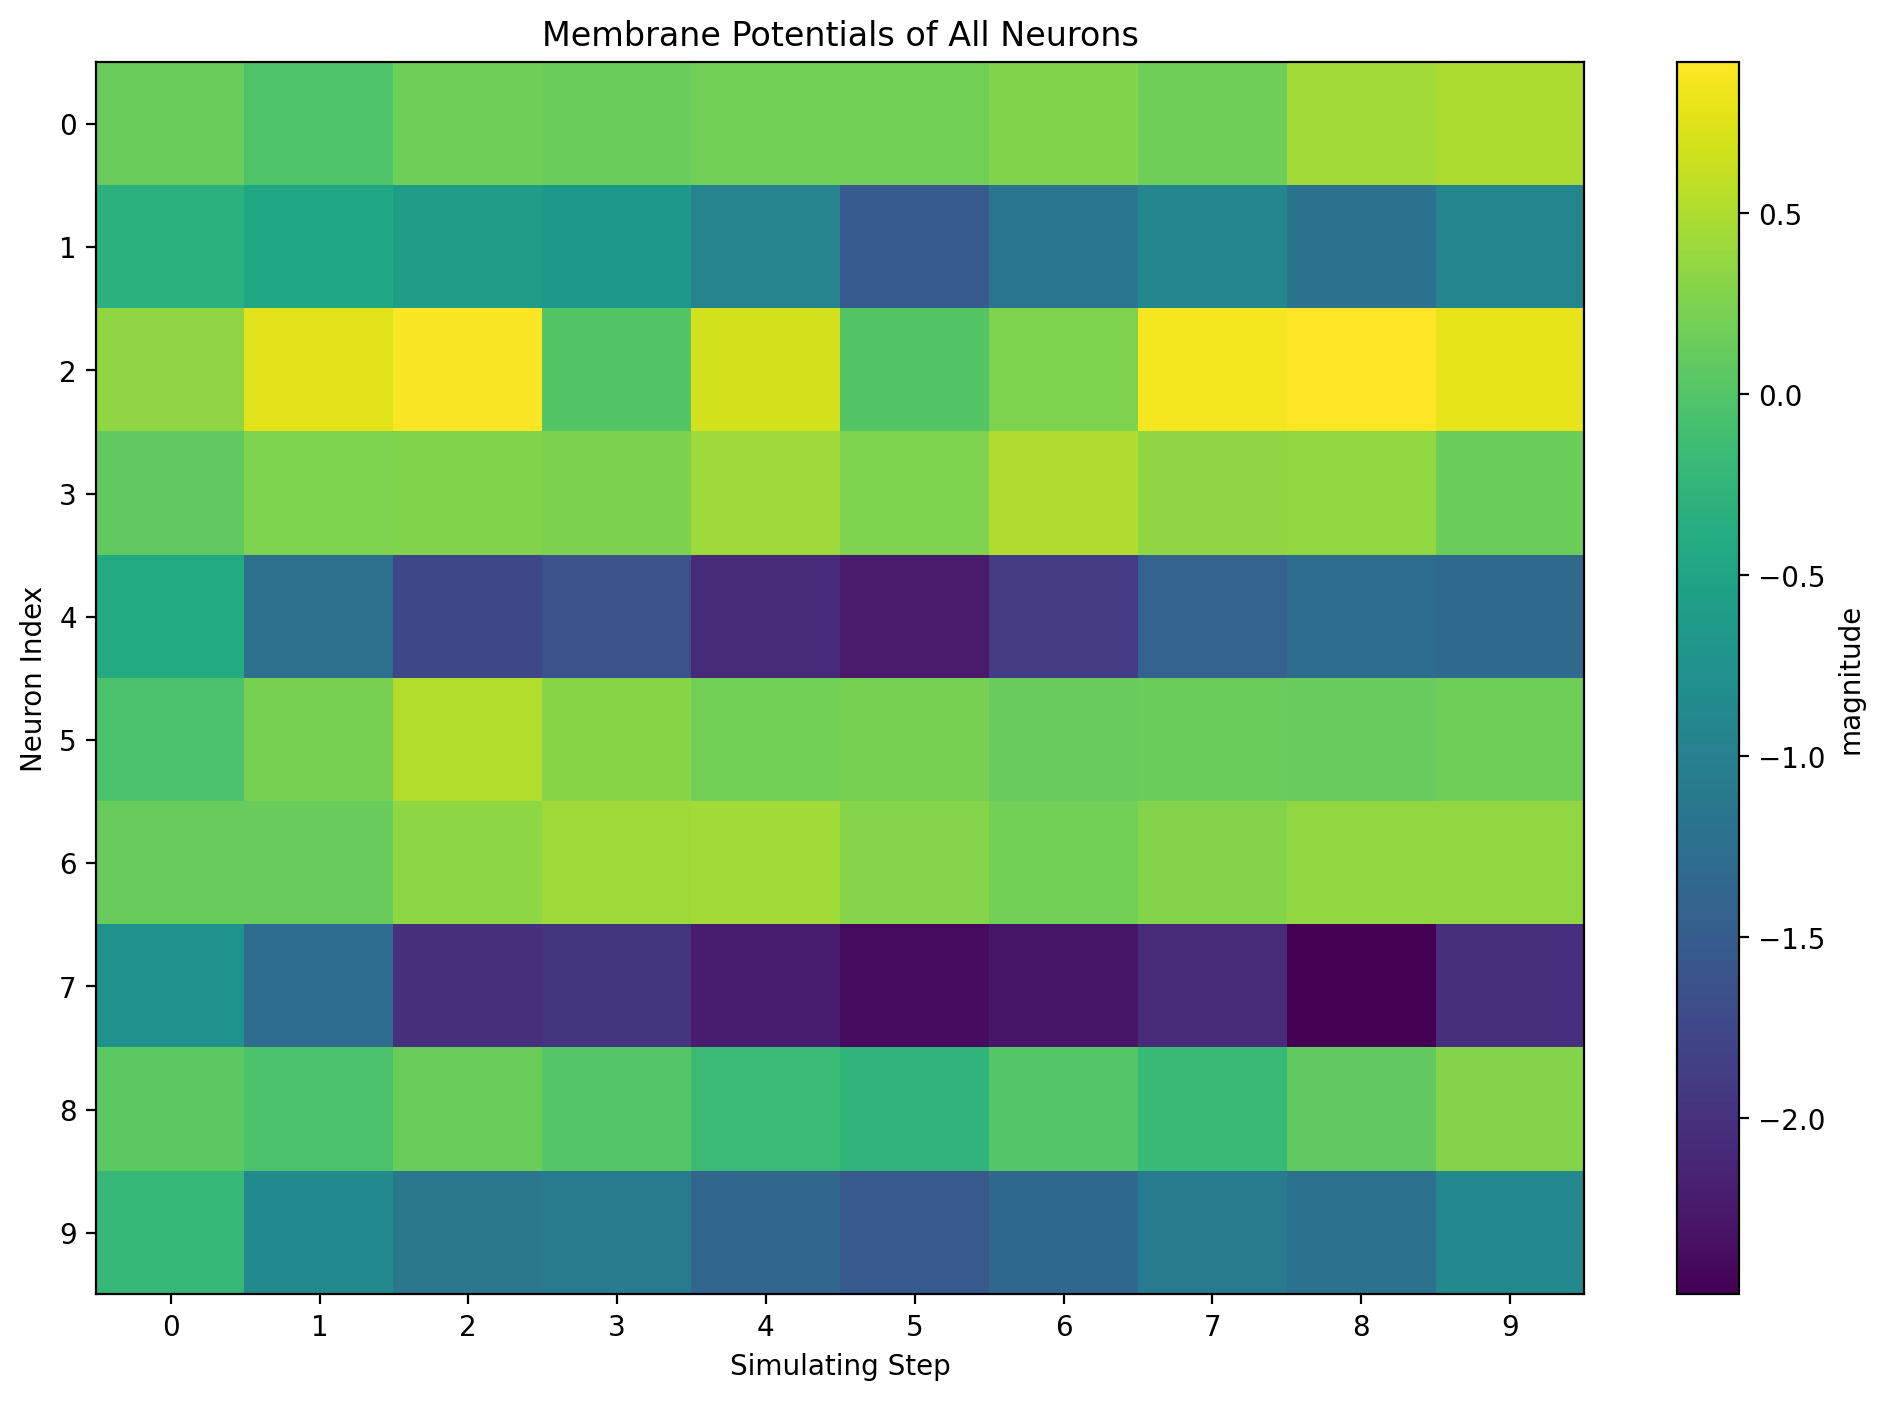

In [20]:
# heatmap
v_seq_tensor = torch.cat(v_seq)
visualizing.plot_2d_heatmap(
    array=v_seq_tensor.numpy(),
    title="Membrane Potentials of All Neurons",
    xlabel = "Simulating Step",
    ylabel = "Neuron Index"
)
plt.show()

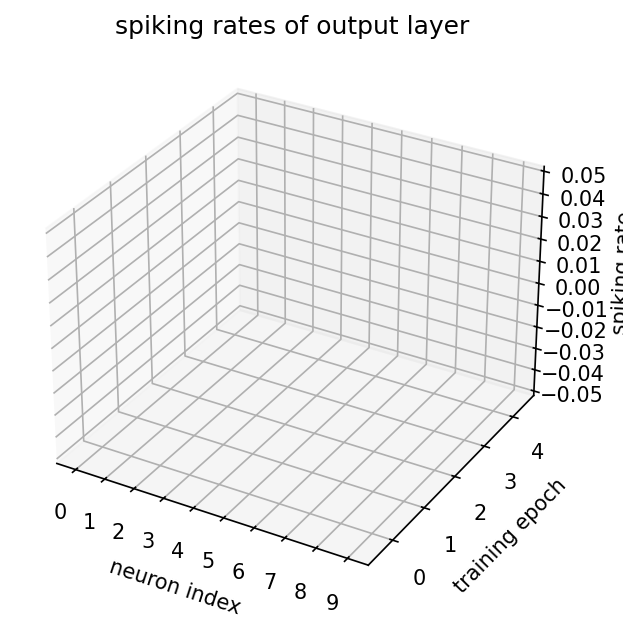

In [ ]:
# 2d bar in 3d
Epochs = 5
N = 10 # 뉴런 수
firing_rate = torch.zeros(Epochs, N)
visualizing.plot_2d_bar_in_3d(
    firing_rate.numpy(),
    title = "spiking rates of output layer",
    xlabel = 'neuron index',
    ylabel = "training epoch",
    zlabel = "spiking rate",
    int_x_ticks = True,
    int_y_ticks = True,
    int_z_ticks = True,
    dpi = 150
)
plt.show()

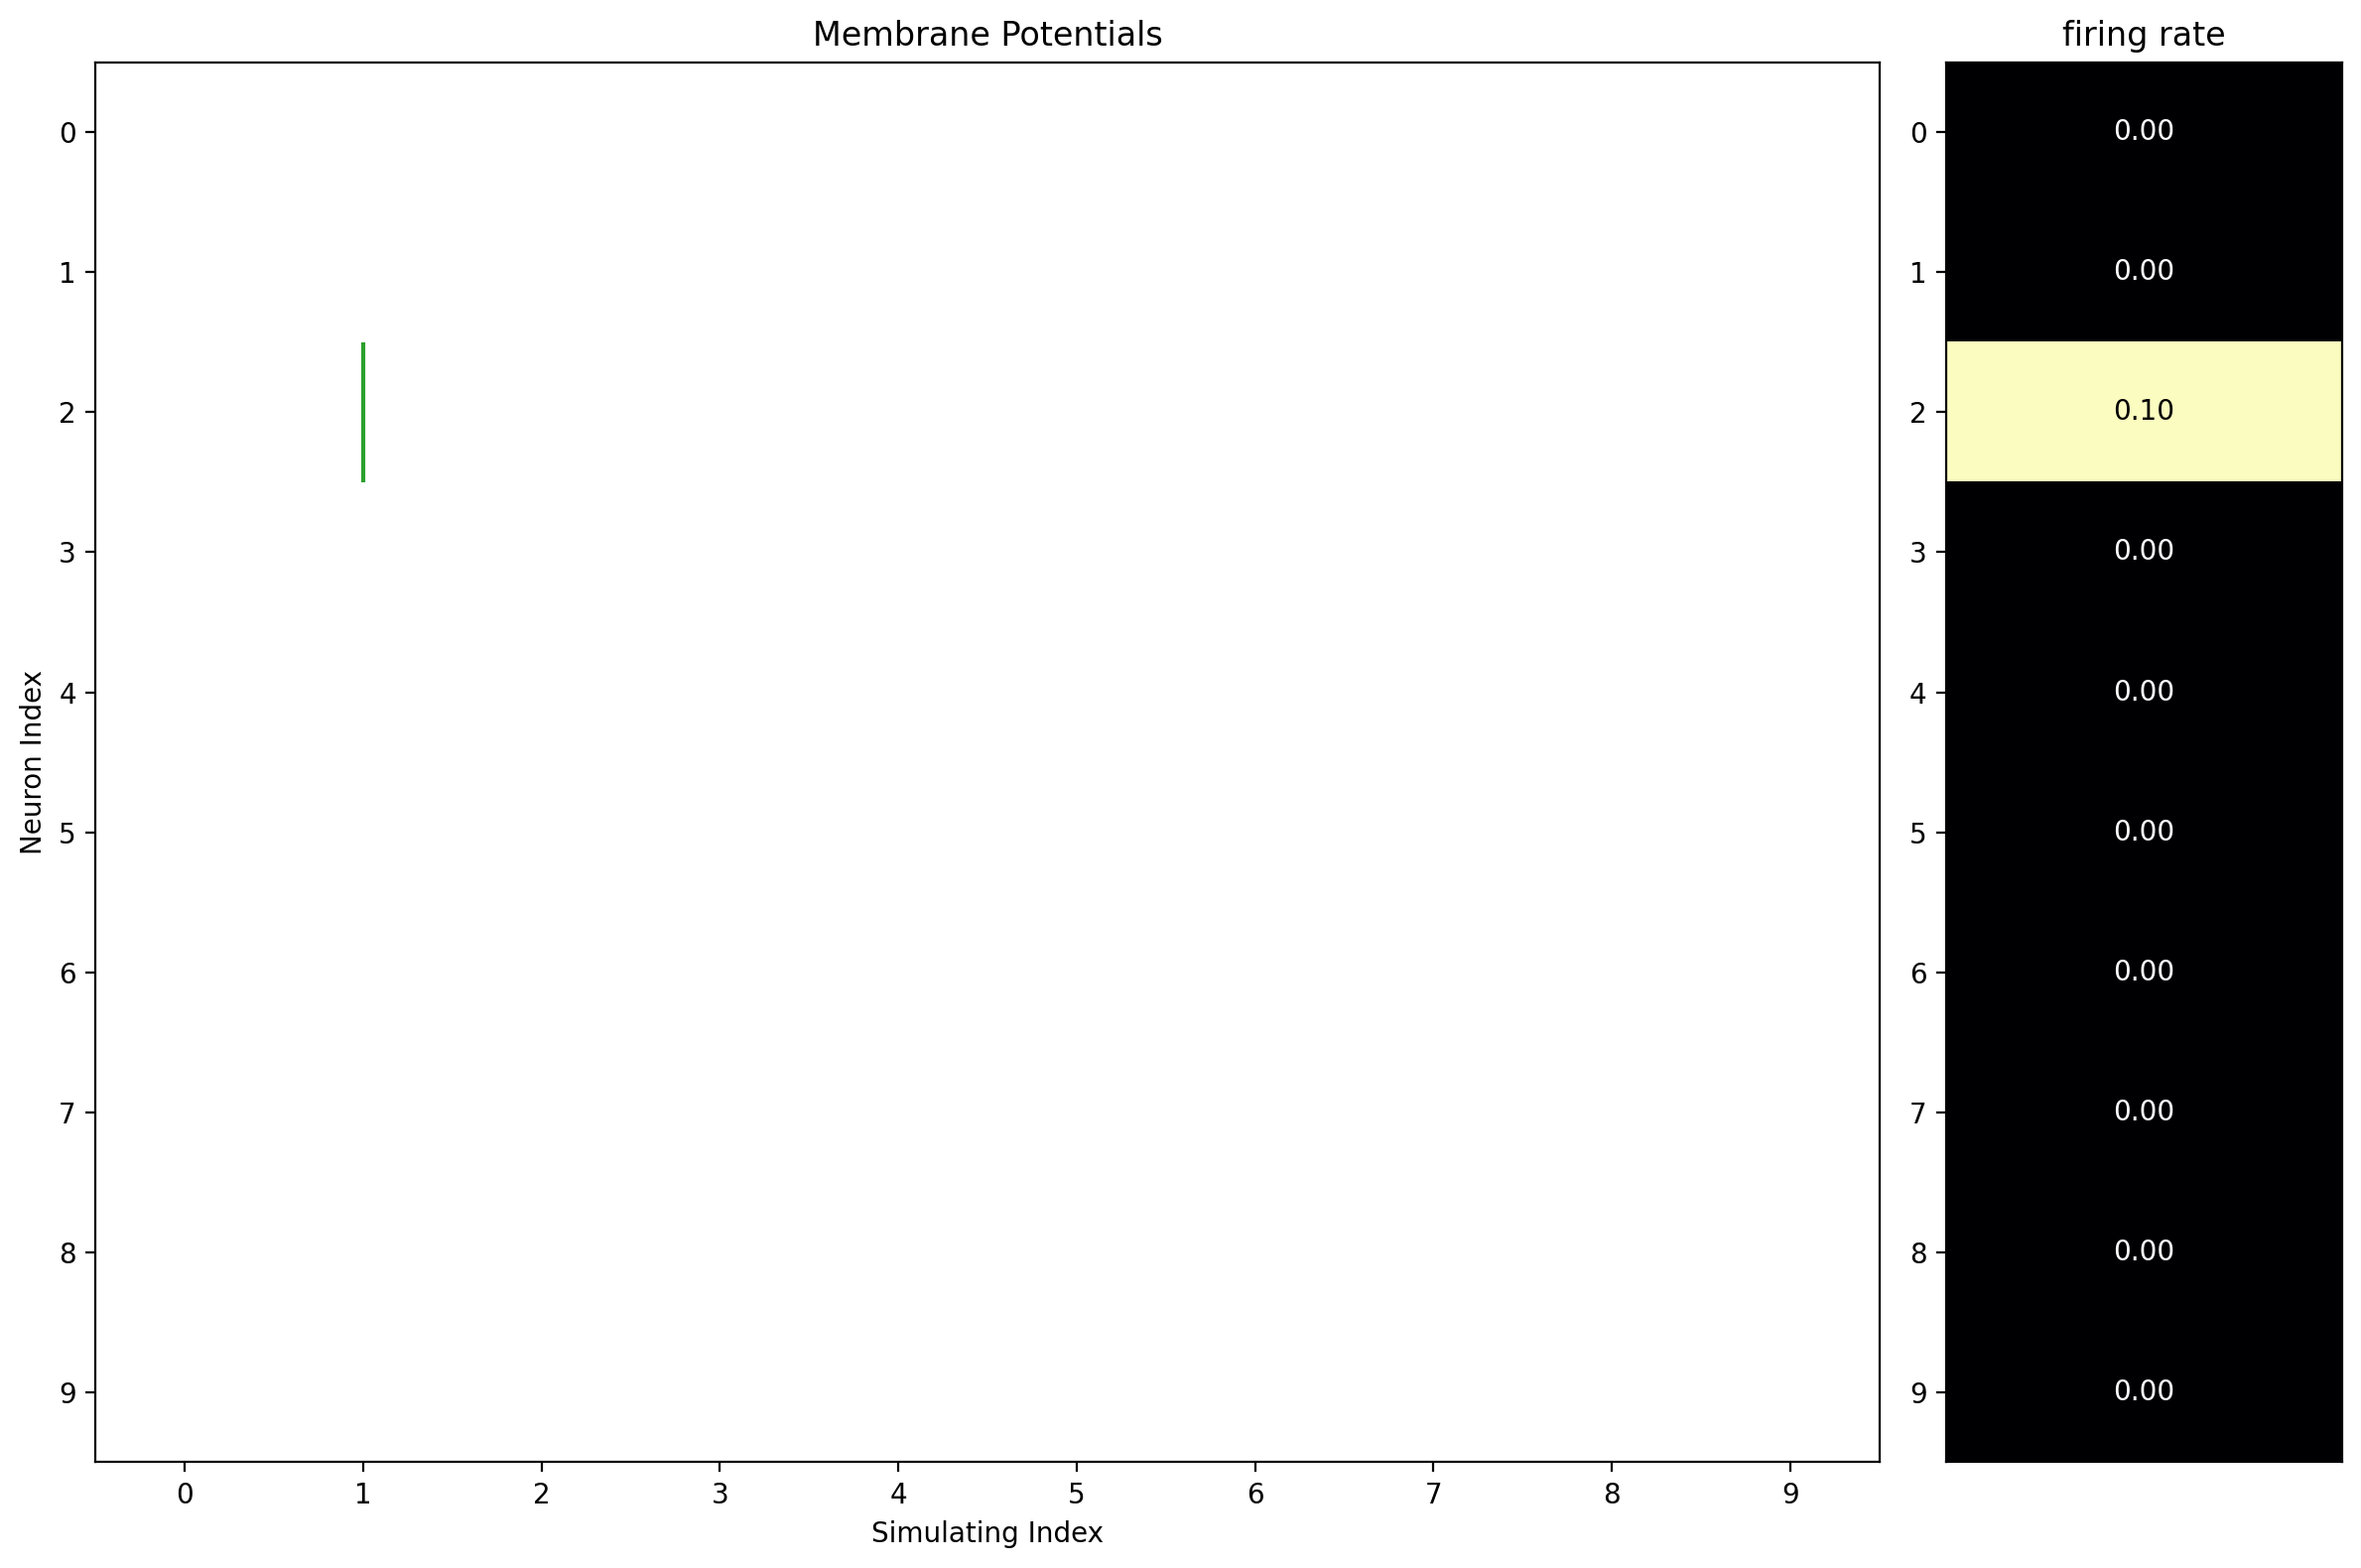

In [24]:
# 1d spikes
s_seq_tensor = torch.cat(s_seq)
visualizing.plot_1d_spikes(
    spikes=np.asarray(s_seq_tensor),
    title="Membrane Potentials",
    xlabel="Simulating Index",
    ylabel="Neuron Index",
    dpi=200
)
plt.show()

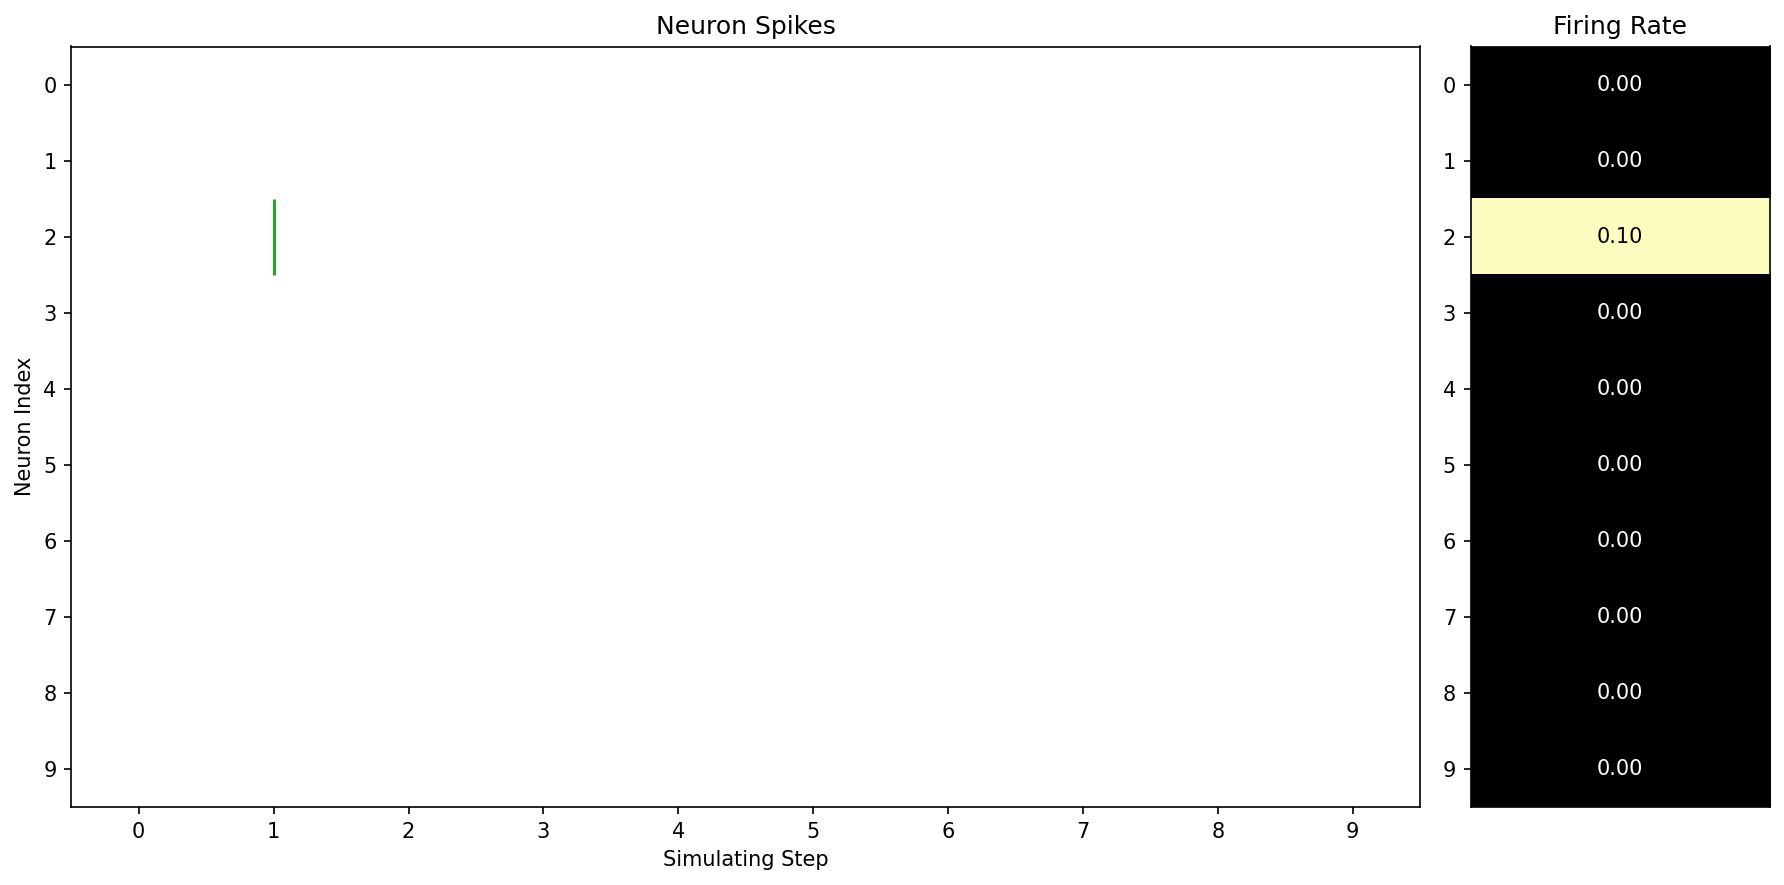

In [ ]:
import matplotlib

spikes = np.asarray(s_seq_tensor)    
spikes_T = spikes.T
plot_firing_rate = True  # True로 설정하면 발화율 표시, False면 표시 안 함
title = "Neuron Spikes"
xlabel = "Simulating Step"
ylabel = "Neuron Index"
figsize = (12, 6)
dpi = 150
int_x_ticks = True
int_y_ticks = True
firing_rate_map_title = "Firing Rate"

if plot_firing_rate:
    fig = plt.figure(tight_layout=True, figsize=figsize, dpi=dpi)
    gs = matplotlib.gridspec.GridSpec(1, 5)
    spikes_map = fig.add_subplot(gs[0, 0:4])
    firing_rate_map = fig.add_subplot(gs[0, 4])
else:
        fig, spikes_map = plt.subplots()

spikes_map.set_title(title)
spikes_map.set_xlabel(xlabel)
spikes_map.set_ylabel(ylabel)

spikes_map.xaxis.set_major_locator(
        matplotlib.ticker.MaxNLocator(integer=int_x_ticks)
    )
spikes_map.yaxis.set_major_locator(
        matplotlib.ticker.MaxNLocator(integer=int_y_ticks)
    )

spikes_map.xaxis.set_minor_locator(matplotlib.ticker.NullLocator())
spikes_map.yaxis.set_minor_locator(matplotlib.ticker.NullLocator())

spikes_map.set_xlim(-0.5, spikes_T.shape[1] - 0.5)
spikes_map.set_ylim(-0.5, spikes_T.shape[0] - 0.5)
spikes_map.invert_yaxis()
N = spikes_T.shape[0]
T = spikes_T.shape[1]
t = np.arange(0, T)
t_spike = spikes_T * t
mask = spikes_T == 1  

colormap = plt.get_cmap(
        "tab10"
    )  

for i in range(N):
        spikes_map.eventplot(
            t_spike[i][mask[i]], lineoffsets=i, colors=colormap(i % 10)
        )

if plot_firing_rate:
        firing_rate = np.mean(spikes_T, axis=1, keepdims=True)

        max_rate = firing_rate.max()
        min_rate = firing_rate.min()

        firing_rate_map.yaxis.set_major_locator(
            matplotlib.ticker.MaxNLocator(integer=True)
        )
        firing_rate_map.yaxis.set_minor_locator(matplotlib.ticker.NullLocator())
        firing_rate_map.imshow(firing_rate, cmap="magma", aspect="auto")
        for i in range(firing_rate.shape[0]):
            firing_rate_map.text(
                0,
                i,
                f"{firing_rate[i][0]:.2f}",
                ha="center",
                va="center",
                color="w"
                if firing_rate[i][0] < 0.7 * max_rate or min_rate == max_rate
                else "black",
            )
        firing_rate_map.get_xaxis().set_visible(False)
        firing_rate_map.set_title(firing_rate_map_title)
plt.show()

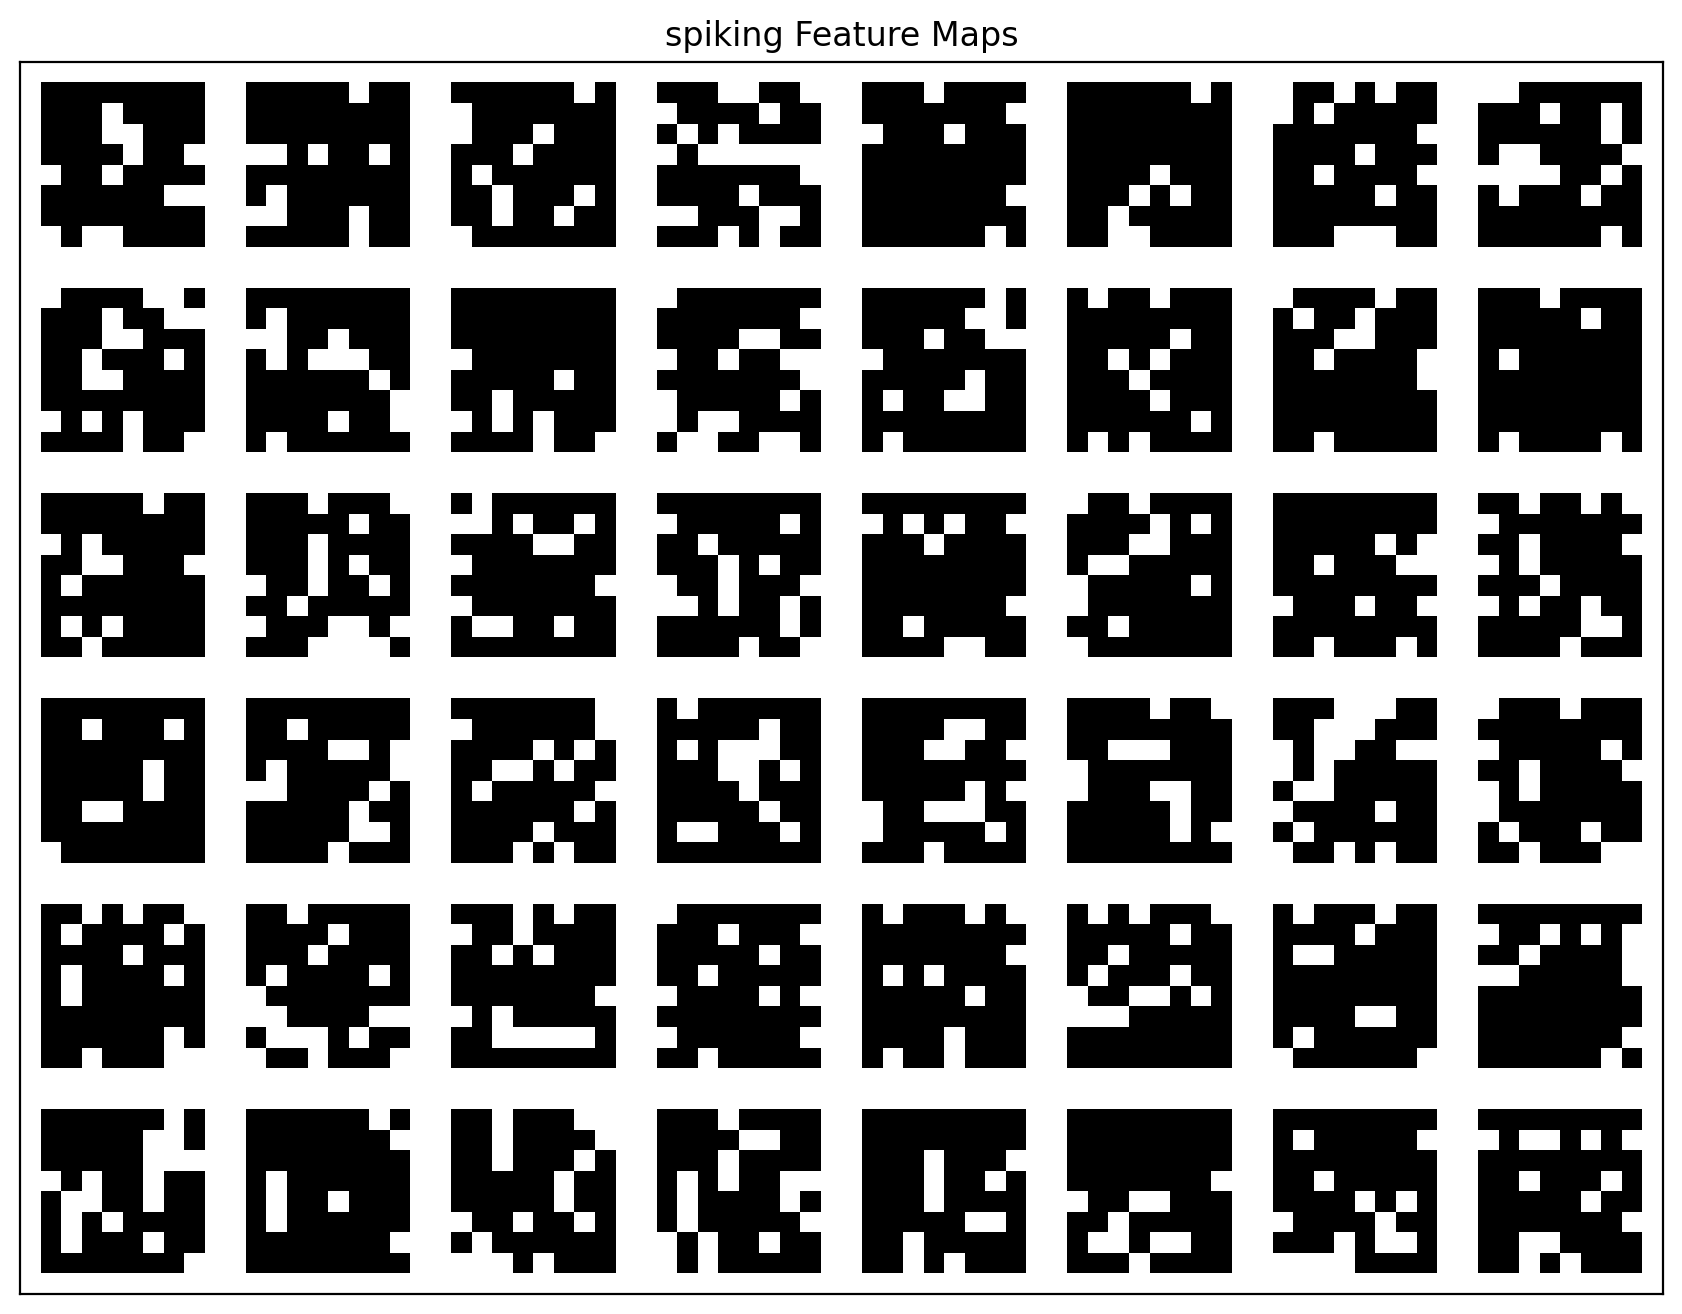

In [ ]:
# 2d feature map
C = 48 # = nrows * ncols
W = 8
H = 8 
spikes = (np.random.rand(C, W, H) > 0.8).astype(float)
visualizing.plot_2d_feature_map(spikes, nrows=6, ncols=8, space=2, title="spiking Feature Maps", dpi=200)
plt.show()

In [ ]:
def plot_2d_feature_map(
    x3d: np.asarray, nrows, ncols, space, title: str, figsize=(12, 8), dpi=200
):
    if x3d.ndim != 3:
        raise ValueError(f"Expected 3D array, got {x3d.ndim}D array instead")

    C = x3d.shape[0]

    assert nrows * ncols == C, "nrows * ncols != C" # C는 채널 수(이미지 수)

    h: int = x3d.shape[1] # 이미지 높이
    w: int = x3d.shape[2] # 이미지 너비
    y = np.ones(shape=[(h + space) * nrows, (w + space) * ncols]) * x3d.max().item()
    index = 0
    for i in range(space // 2, y.shape[0], h + space):
        for j in range(space // 2, y.shape[1], w + space):
            y[i : i + h, j : j + w] = x3d[index]
            index += 1
    fig, maps = plt.subplots(figsize=figsize, dpi=dpi)
    maps.set_title(title)
    maps.imshow(y, cmap="gray")

    maps.get_xaxis().set_visible(False)
    maps.get_yaxis().set_visible(False)
    return fig, maps

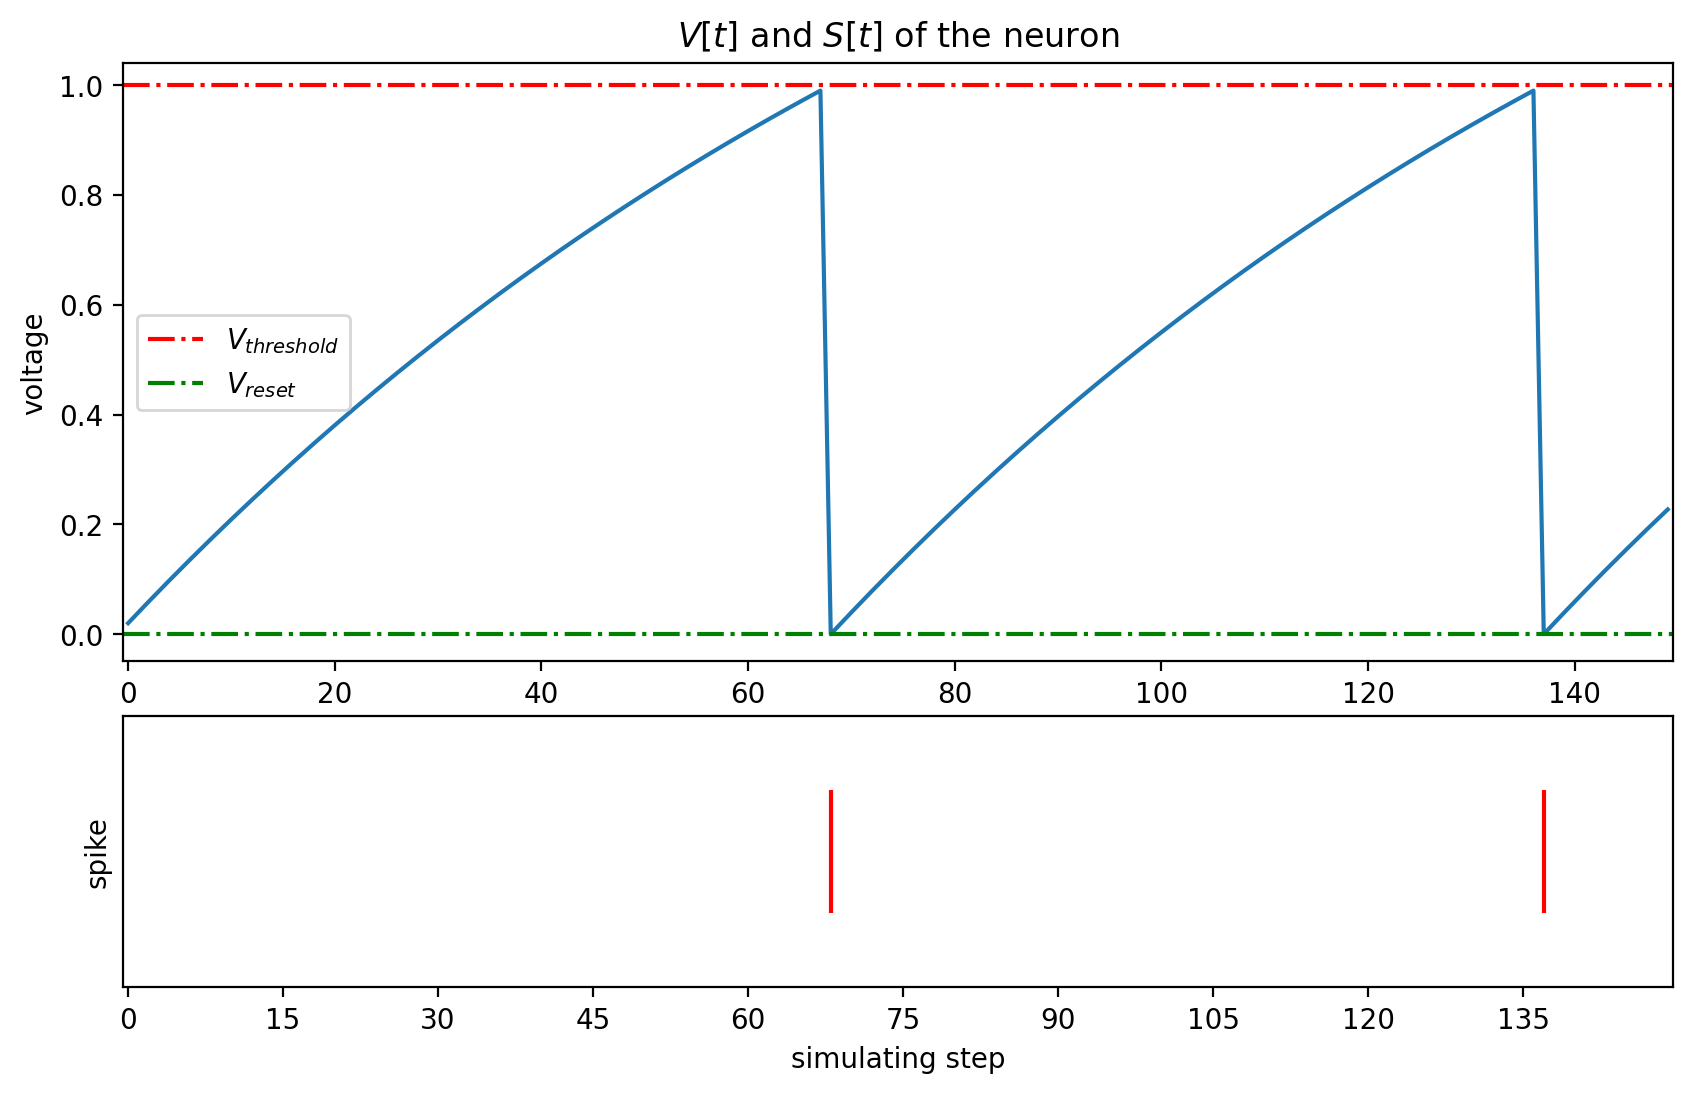

In [47]:
# plot_one_neuron_v_s
lif = neuron.LIFNode(tau=100.0)
x = torch.Tensor([2.0])
num_steps = 150
s_list = []
v_list = []
for t in range(num_steps):
    s_list.append(lif(x))
    v_list.append(lif.v)
s_list = torch.stack(s_list).squeeze()
v_list = torch.stack(v_list).squeeze()
visualizing.plot_one_neuron_v_s(
    v_list, s_list, v_threshold=lif.v_threshold, v_reset=lif.v_reset, dpi=200, figsize=(10, 6)
)
plt.show()